In [2]:
# Import modules

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick  # Import PercentFormatter


In [3]:
# Load data
data_4hrs_actual = pd.read_csv('data\historic_actuals.csv')

# Rename month column, filter error months, and set data type to date
data_4hrs_actual = data_4hrs_actual.rename(columns={'DimDateStart': 'date', '4hrs': 'value'})

data_4hrs_actual['date'] = pd.to_datetime(data_4hrs_actual['date'])

data_4hrs_actual.head()

,date,value
0,2023-11-01,0.661973
1,2022-04-01,0.597537
2,2023-12-01,0.654668
3,2022-09-01,0.578044
4,2025-01-01,0.714621


In [4]:
# Load plan data
data_4hrs_plan = pd.read_csv('data\plans_1.csv')

# Rename month column, filter error months, and set data type to date
data_4hrs_plan = data_4hrs_plan.rename(columns={'DimDateStart': 'date', '4hrs': 'plan'})

data_4hrs_plan['date'] = pd.to_datetime(data_4hrs_plan['date'])

data_4hrs_plan.head()

,date,plan
0,NaT,0.746212
1,2025-05-01,0.734329
2,2026-03-01,0.781982
3,2025-11-01,0.738549
4,2026-02-01,0.750239


In [7]:
# Check stationarity using ADF test
from statsmodels.tsa.stattools import adfuller

result = adfuller(data_4hrs_forecast['value'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"critial values: {result[4]}")
print(f"p-value: {result[1]}")

# If p-value > 0.05, data is non-stationary, so we need to difference it
if result[1] > 0.05:
    data_4hrs_forecast['value'] = data_4hrs_forecast['value'].diff().dropna()
    data_4hrs_forecast = data_4hrs_forecast.dropna()

ADF Statistic: -2.854151842765923
critial values: {'1%': -3.7238633119999998, '5%': -2.98648896, '10%': -2.6328004}
p-value: 0.050945188790465765


c:\Users\martin.bloyce2\AppData\Local\anaconda3\envs\hsma_forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\martin.bloyce2\AppData\Local\anaconda3\envs\hsma_forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\martin.bloyce2\AppData\Local\anaconda3\envs\hsma_forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\martin.bloyce2\AppData\Local\anaconda3\envs\hsma_forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: 

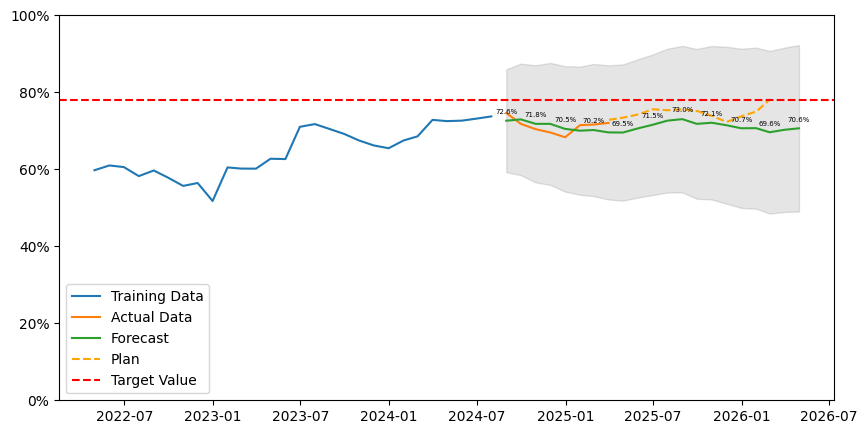

Probability of hitting the target by 2026-03-31: 100.00%
Last date in training data: 2024-07-31 00:00:00


In [5]:
data_4hrs_forecast = data_4hrs_actual

# Ensure the date column is parsed as datetime and set as index
# data_52wks_forecast['date'] = pd.to_datetime(data_52wks_forecast['date'])
data_4hrs_forecast = data_4hrs_forecast.set_index('date')

# Ensure data is in monthly frequency
data_4hrs_forecast = data_4hrs_forecast.resample('M').mean()

# Combine the date ranges from forecast and plan
combined_dates = data_4hrs_forecast.index.union(data_4hrs_plan['date'])

# Reindex data_4hrs_forecast to include all dates in the combined range
data_4hrs_forecast = data_4hrs_forecast.reindex(combined_dates)

# Reset plan index to match forecast index
data_4hrs_plan = data_4hrs_plan.set_index('date').reindex(data_4hrs_forecast.index).reset_index()

# Select the column to use for ARIMA model
endog = data_4hrs_forecast['value']

# Define the target date and value
target_date = '2026-03-31'
target_value = 0.78 # NHS 4 hour target

# Split data into training and testing sets
# Find the length of data_4hrs_forecast ignoring missing values
length = len(data_4hrs_forecast.dropna())
train = data_4hrs_forecast[:int(0.8*length)]
test = data_4hrs_forecast[int(0.8*length):]

# Fit ARIMA model
model = ARIMA(endog, order=(20,1,0))
model_fit = model.fit()

# Forecast up to the target date
forecast_steps = len(pd.date_range(start=train.index[-1], end=target_date, freq='M'))
forecast_result = model_fit.get_forecast(steps=forecast_steps)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Create a date range for the forecast
forecast_index = pd.date_range(start=train.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Plot forecast with confidence intervals
plt.figure(figsize=(10,5))
plt.plot(train.index, train['value'], label='Training Data')
plt.plot(test.index, test['value'], label='Actual Data')
plt.plot(forecast_index, forecast, label='Forecast')

# Add data labels to the forecast line for every other month
for i, (x, y) in enumerate(zip(forecast_index, forecast)):
    if i % 2 == 0:  # Show label only for every other month
        plt.annotate(f'{y * 100:.1f}%', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=5)

plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='k', alpha=0.1)
# Plot the plan data from data_4hrs_plan
plt.plot(data_4hrs_plan['date'], data_4hrs_plan['plan'], label='Plan', color='orange', linestyle='--')

plt.axhline(y=target_value, color='r', linestyle='--', label='Target Value')

# Set y axis limits
plt.ylim(0, 1)  # Set y-axis limits to 0 and 1 (0% to 100%)

# Set y-axis to percentage
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # Scale values to percentage

# plt.plot(data_52wks_forecast.index, data_52wks_forecast['plan'], label='Plan', color='orange')
plt.legend()
plt.show()

# Calculate probability of hitting target on the target date
target_conf_int = conf_int.iloc[-1]  # Confidence interval on the target date
probability = np.mean((target_conf_int[0] <= target_value) & (target_conf_int[1] >= target_value))
print(f'Probability of hitting the target by {target_date}: {probability*100:.2f}%')

print("Last date in training data:", train.index[-1])